In [4]:
# import all necessery library

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from model import CNN_model

### Reading CIFAR 10 data set & augmentation

In [5]:
# Finding mean & stdv of CIFAR10 dataset

CIFAR_train = torchvision.datasets.CIFAR10(root='./data', train=True,download=True)
CIFAR_test = torchvision.datasets.CIFAR10(root='./data', train=False,download=True)


data = CIFAR_train.data / 255 # data is numpy array
mean = data.mean(axis = (0,1,2))
std = data.std(axis = (0,1,2))
print(f"Mean : {mean} ,STD: {std} ")
print(f"No. of classes :{CIFAR_train.classes}")
print(f"No. of images in train :{len(CIFAR_train)} , test : {len(CIFAR_test)}")
x = np.asarray(CIFAR_train[1][0])
print(f"Images size : {x.shape}")


100%|██████████| 170498071/170498071 [00:04<00:00, 39546206.82it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Mean : [0.49139968 0.48215841 0.44653091] ,STD: [0.24703223 0.24348513 0.26158784] 
No. of classes :['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
No. of images in train :50000 , test : 10000
Images size : (32, 32, 3)


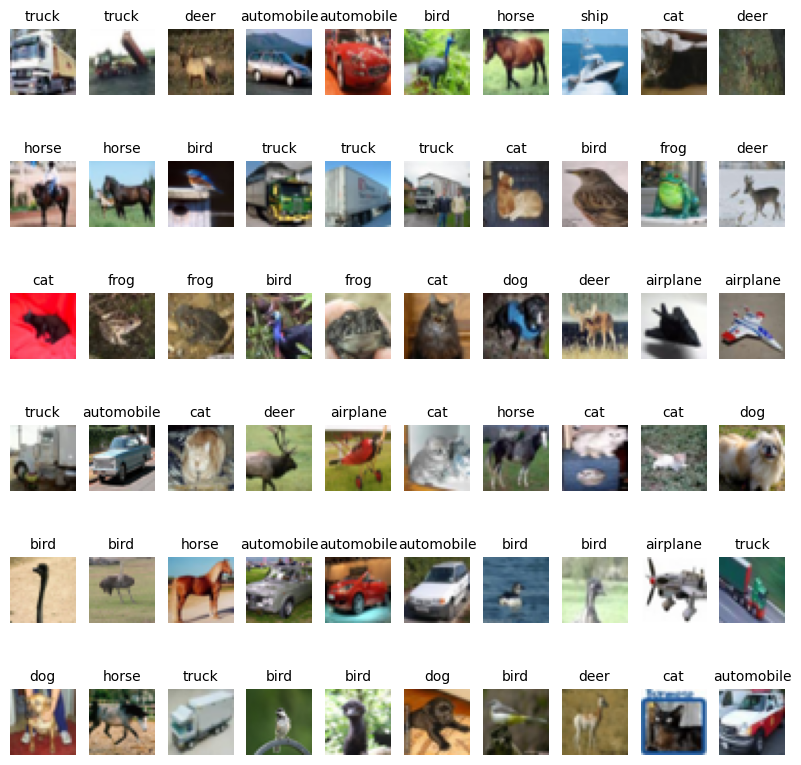

In [6]:
# Plotting the images of CIFAR10

%matplotlib inline
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(10,10))
num_of_images = 60

for i in range(1,num_of_images+1):

  plt.subplot(6, 10, i)
  plt.axis('off')
  plt.title(CIFAR_train.classes[CIFAR_train[i][1]],fontsize=10)
  plt.imshow(np.asarray(CIFAR_train[i][0]), cmap='gray_r')


In [7]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,1,1)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215841, 0.44653091),(0.24703223, 0.24348513, 0.26158784)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215841, 0.44653091),(0.24703223, 0.24348513, 0.26158784))
                                       ])

In [8]:
# Download data and apply transformation

train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Data loader arguments

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=128)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Model Summary

In [10]:
# Batch normalization summary

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = CNN_model('BN').to(device)
print("Batch Normalization Model")
summary(model, input_size=(3, 32, 32))

Batch Normalization Model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
              ReLU-2            [-1, 8, 32, 32]               0
       BatchNorm2d-3            [-1, 8, 32, 32]              16
           Dropout-4            [-1, 8, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           1,152
              ReLU-6           [-1, 16, 32, 32]               0
       BatchNorm2d-7           [-1, 16, 32, 32]              32
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9            [-1, 8, 34, 34]             128
        MaxPool2d-10            [-1, 8, 17, 17]               0
           Conv2d-11           [-1, 16, 17, 17]           1,152
             ReLU-12           [-1, 16, 17, 17]               0
      BatchNorm2d-13           [-1, 16, 17, 17]              32
          Dro

In [11]:
# Layer normalization summary

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = CNN_model('LN').to(device)
print("Layer Normalization Model")
summary(model, input_size=(3, 32, 32))

Layer Normalization Model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
              ReLU-2            [-1, 8, 32, 32]               0
         GroupNorm-3            [-1, 8, 32, 32]              16
           Dropout-4            [-1, 8, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           1,152
              ReLU-6           [-1, 16, 32, 32]               0
         GroupNorm-7           [-1, 16, 32, 32]              32
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9            [-1, 8, 34, 34]             128
        MaxPool2d-10            [-1, 8, 17, 17]               0
           Conv2d-11           [-1, 16, 17, 17]           1,152
             ReLU-12           [-1, 16, 17, 17]               0
        GroupNorm-13           [-1, 16, 17, 17]              32
          Dro

In [12]:
# Group normalization summary

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = CNN_model('GN').to(device)
print("Group Normalization Model")
summary(model, input_size=(3, 32, 32))

Group Normalization Model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
              ReLU-2            [-1, 8, 32, 32]               0
         GroupNorm-3            [-1, 8, 32, 32]              16
           Dropout-4            [-1, 8, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           1,152
              ReLU-6           [-1, 16, 32, 32]               0
         GroupNorm-7           [-1, 16, 32, 32]              32
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9            [-1, 8, 34, 34]             128
        MaxPool2d-10            [-1, 8, 17, 17]               0
           Conv2d-11           [-1, 16, 17, 17]           1,152
             ReLU-12           [-1, 16, 17, 17]               0
        GroupNorm-13           [-1, 16, 17, 17]              32
          Dro

### Training and Validation

In [13]:

def train(model, device, train_loader, optimizer, epoch):

    train_acc = []
    train_losses = []

    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        #print(y_pred.shape)
        #print(target.shape)
        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

    return train_acc,train_losses


def test(model, device, test_loader):
    test_losses = []
    test_acc = []

    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_acc,test_losses


### Model training and validation

In [14]:
from torch.optim.lr_scheduler import StepLR

EPOCHS = 20

print('######################################### Batch Normalization ###################################################')

model =  CNN_model('BN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    BN_train_acc,BN_train_loss = train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    BN_test_acc,BN_test_loss = test(model, device, test_loader)


print('######################################### Group Normalization ###################################################')

model =  CNN_model('GN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    GN_train_acc,GN_train_loss = train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    GN_test_acc,GN_test_loss = test(model, device, test_loader)


print('######################################### Layer Normalization ###################################################')

model =  CNN_model('LN').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    LN_train_acc,LN_train_loss = train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    LN_test_acc,LN_test_loss = test(model, device, test_loader)


######################################### Batch Normalization ###################################################
EPOCH: 0


Loss=1.2787293195724487 Batch_id=390 Accuracy=40.40: 100%|██████████| 391/391 [00:23<00:00, 16.45it/s]



Test set: Average loss: 1.4405, Accuracy: 4611/10000 (46.11%)

EPOCH: 1


Loss=1.1725523471832275 Batch_id=390 Accuracy=54.11: 100%|██████████| 391/391 [00:22<00:00, 17.36it/s]



Test set: Average loss: 1.1942, Accuracy: 5610/10000 (56.10%)

EPOCH: 2


Loss=1.1755470037460327 Batch_id=390 Accuracy=59.12: 100%|██████████| 391/391 [00:22<00:00, 17.56it/s]



Test set: Average loss: 1.0769, Accuracy: 6079/10000 (60.79%)

EPOCH: 3


Loss=1.2075376510620117 Batch_id=390 Accuracy=62.23: 100%|██████████| 391/391 [00:22<00:00, 17.71it/s]



Test set: Average loss: 1.0698, Accuracy: 6084/10000 (60.84%)

EPOCH: 4


Loss=1.1267422437667847 Batch_id=390 Accuracy=64.25: 100%|██████████| 391/391 [00:22<00:00, 17.21it/s]



Test set: Average loss: 0.9815, Accuracy: 6454/10000 (64.54%)

EPOCH: 5


Loss=0.9200860857963562 Batch_id=390 Accuracy=65.66: 100%|██████████| 391/391 [00:23<00:00, 16.56it/s]



Test set: Average loss: 0.9490, Accuracy: 6586/10000 (65.86%)

EPOCH: 6


Loss=0.8998197317123413 Batch_id=390 Accuracy=68.86: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s]



Test set: Average loss: 0.8527, Accuracy: 6906/10000 (69.06%)

EPOCH: 7


Loss=0.9184379577636719 Batch_id=390 Accuracy=69.68: 100%|██████████| 391/391 [00:24<00:00, 16.19it/s]



Test set: Average loss: 0.8465, Accuracy: 6950/10000 (69.50%)

EPOCH: 8


Loss=0.7799896001815796 Batch_id=390 Accuracy=69.61: 100%|██████████| 391/391 [00:23<00:00, 16.51it/s]



Test set: Average loss: 0.8392, Accuracy: 6959/10000 (69.59%)

EPOCH: 9


Loss=0.8865369558334351 Batch_id=390 Accuracy=70.00: 100%|██████████| 391/391 [00:23<00:00, 16.53it/s]



Test set: Average loss: 0.8388, Accuracy: 6983/10000 (69.83%)

EPOCH: 10


Loss=0.8885606527328491 Batch_id=390 Accuracy=70.19: 100%|██████████| 391/391 [00:23<00:00, 16.73it/s]



Test set: Average loss: 0.8430, Accuracy: 6985/10000 (69.85%)

EPOCH: 11


Loss=0.7565613985061646 Batch_id=390 Accuracy=70.59: 100%|██████████| 391/391 [00:23<00:00, 16.86it/s]



Test set: Average loss: 0.8298, Accuracy: 6984/10000 (69.84%)

EPOCH: 12


Loss=0.8475885391235352 Batch_id=390 Accuracy=70.96: 100%|██████████| 391/391 [00:23<00:00, 16.76it/s]



Test set: Average loss: 0.8263, Accuracy: 7020/10000 (70.20%)

EPOCH: 13


Loss=0.7745037078857422 Batch_id=390 Accuracy=70.85: 100%|██████████| 391/391 [00:23<00:00, 16.98it/s]



Test set: Average loss: 0.8255, Accuracy: 7018/10000 (70.18%)

EPOCH: 14


Loss=0.8793760538101196 Batch_id=390 Accuracy=71.05: 100%|██████████| 391/391 [00:23<00:00, 16.61it/s]



Test set: Average loss: 0.8304, Accuracy: 7021/10000 (70.21%)

EPOCH: 15


Loss=0.8514716029167175 Batch_id=390 Accuracy=71.09: 100%|██████████| 391/391 [00:22<00:00, 17.08it/s]



Test set: Average loss: 0.8240, Accuracy: 7045/10000 (70.45%)

EPOCH: 16


Loss=0.8938628435134888 Batch_id=390 Accuracy=71.06: 100%|██████████| 391/391 [00:23<00:00, 16.69it/s]



Test set: Average loss: 0.8213, Accuracy: 7050/10000 (70.50%)

EPOCH: 17


Loss=0.7732521891593933 Batch_id=390 Accuracy=70.75: 100%|██████████| 391/391 [00:23<00:00, 16.86it/s]



Test set: Average loss: 0.8298, Accuracy: 7021/10000 (70.21%)

EPOCH: 18


Loss=0.7693384885787964 Batch_id=390 Accuracy=70.93: 100%|██████████| 391/391 [00:21<00:00, 17.95it/s]



Test set: Average loss: 0.8290, Accuracy: 7030/10000 (70.30%)

EPOCH: 19


Loss=0.8139158487319946 Batch_id=390 Accuracy=71.04: 100%|██████████| 391/391 [00:21<00:00, 17.90it/s]



Test set: Average loss: 0.8266, Accuracy: 7023/10000 (70.23%)

######################################### Group Normalization ###################################################
EPOCH: 0


Loss=1.5021482706069946 Batch_id=390 Accuracy=34.54: 100%|██████████| 391/391 [00:21<00:00, 17.84it/s]



Test set: Average loss: 1.5221, Accuracy: 4343/10000 (43.43%)

EPOCH: 1


Loss=1.1423031091690063 Batch_id=390 Accuracy=49.93: 100%|██████████| 391/391 [00:21<00:00, 17.87it/s]



Test set: Average loss: 1.2029, Accuracy: 5627/10000 (56.27%)

EPOCH: 2


Loss=1.1296539306640625 Batch_id=390 Accuracy=56.53: 100%|██████████| 391/391 [00:22<00:00, 17.51it/s]



Test set: Average loss: 1.1205, Accuracy: 5907/10000 (59.07%)

EPOCH: 3


Loss=1.1576899290084839 Batch_id=390 Accuracy=59.84: 100%|██████████| 391/391 [00:22<00:00, 17.71it/s]



Test set: Average loss: 1.1044, Accuracy: 6020/10000 (60.20%)

EPOCH: 4


Loss=1.0112404823303223 Batch_id=390 Accuracy=62.57: 100%|██████████| 391/391 [00:22<00:00, 17.63it/s]



Test set: Average loss: 0.9996, Accuracy: 6432/10000 (64.32%)

EPOCH: 5


Loss=0.7528786063194275 Batch_id=390 Accuracy=64.04: 100%|██████████| 391/391 [00:22<00:00, 17.14it/s]



Test set: Average loss: 0.9549, Accuracy: 6591/10000 (65.91%)

EPOCH: 6


Loss=1.0002944469451904 Batch_id=390 Accuracy=68.16: 100%|██████████| 391/391 [00:22<00:00, 17.50it/s]



Test set: Average loss: 0.9035, Accuracy: 6750/10000 (67.50%)

EPOCH: 7


Loss=1.2401211261749268 Batch_id=390 Accuracy=69.04: 100%|██████████| 391/391 [00:22<00:00, 17.69it/s]



Test set: Average loss: 0.8906, Accuracy: 6822/10000 (68.22%)

EPOCH: 8


Loss=0.9976345896720886 Batch_id=390 Accuracy=69.30: 100%|██████████| 391/391 [00:22<00:00, 17.33it/s]



Test set: Average loss: 0.8813, Accuracy: 6830/10000 (68.30%)

EPOCH: 9


Loss=1.035819172859192 Batch_id=390 Accuracy=69.73: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s]



Test set: Average loss: 0.8867, Accuracy: 6831/10000 (68.31%)

EPOCH: 10


Loss=0.7733039259910583 Batch_id=390 Accuracy=69.55: 100%|██████████| 391/391 [00:22<00:00, 17.74it/s]



Test set: Average loss: 0.8815, Accuracy: 6839/10000 (68.39%)

EPOCH: 11


Loss=0.7790883779525757 Batch_id=390 Accuracy=69.79: 100%|██████████| 391/391 [00:21<00:00, 18.03it/s]



Test set: Average loss: 0.8687, Accuracy: 6904/10000 (69.04%)

EPOCH: 12


Loss=1.0846576690673828 Batch_id=390 Accuracy=70.29: 100%|██████████| 391/391 [00:21<00:00, 17.89it/s]



Test set: Average loss: 0.8578, Accuracy: 6951/10000 (69.51%)

EPOCH: 13


Loss=0.7299003005027771 Batch_id=390 Accuracy=70.71: 100%|██████████| 391/391 [00:22<00:00, 17.11it/s]



Test set: Average loss: 0.8593, Accuracy: 6916/10000 (69.16%)

EPOCH: 14


Loss=0.9669458270072937 Batch_id=390 Accuracy=70.51: 100%|██████████| 391/391 [00:23<00:00, 16.62it/s]



Test set: Average loss: 0.8578, Accuracy: 6921/10000 (69.21%)

EPOCH: 15


Loss=0.6662667989730835 Batch_id=390 Accuracy=70.55: 100%|██████████| 391/391 [00:23<00:00, 16.87it/s]



Test set: Average loss: 0.8588, Accuracy: 6916/10000 (69.16%)

EPOCH: 16


Loss=0.7823953032493591 Batch_id=390 Accuracy=70.53: 100%|██████████| 391/391 [00:23<00:00, 16.51it/s]



Test set: Average loss: 0.8577, Accuracy: 6925/10000 (69.25%)

EPOCH: 17


Loss=0.7688603401184082 Batch_id=390 Accuracy=70.87: 100%|██████████| 391/391 [00:23<00:00, 16.52it/s]



Test set: Average loss: 0.8571, Accuracy: 6926/10000 (69.26%)

EPOCH: 18


Loss=0.7837795615196228 Batch_id=390 Accuracy=70.56: 100%|██████████| 391/391 [00:23<00:00, 16.62it/s]



Test set: Average loss: 0.8556, Accuracy: 6937/10000 (69.37%)

EPOCH: 19


Loss=0.7933716773986816 Batch_id=390 Accuracy=70.54: 100%|██████████| 391/391 [00:23<00:00, 16.78it/s]



Test set: Average loss: 0.8548, Accuracy: 6935/10000 (69.35%)

######################################### Layer Normalization ###################################################
EPOCH: 0


Loss=1.6516993045806885 Batch_id=390 Accuracy=33.94: 100%|██████████| 391/391 [00:23<00:00, 16.75it/s]



Test set: Average loss: 1.5175, Accuracy: 4433/10000 (44.33%)

EPOCH: 1


Loss=1.3690494298934937 Batch_id=390 Accuracy=47.38: 100%|██████████| 391/391 [00:23<00:00, 16.99it/s]



Test set: Average loss: 1.3449, Accuracy: 5051/10000 (50.51%)

EPOCH: 2


Loss=1.1439141035079956 Batch_id=390 Accuracy=53.68: 100%|██████████| 391/391 [00:23<00:00, 16.68it/s]



Test set: Average loss: 1.2555, Accuracy: 5405/10000 (54.05%)

EPOCH: 3


Loss=1.0656453371047974 Batch_id=390 Accuracy=57.62: 100%|██████████| 391/391 [00:23<00:00, 16.89it/s]



Test set: Average loss: 1.1679, Accuracy: 5727/10000 (57.27%)

EPOCH: 4


Loss=0.988201916217804 Batch_id=390 Accuracy=60.62: 100%|██████████| 391/391 [00:23<00:00, 16.37it/s]



Test set: Average loss: 1.0564, Accuracy: 6227/10000 (62.27%)

EPOCH: 5


Loss=1.0198862552642822 Batch_id=390 Accuracy=62.39: 100%|██████████| 391/391 [00:23<00:00, 16.72it/s]



Test set: Average loss: 1.0246, Accuracy: 6342/10000 (63.42%)

EPOCH: 6


Loss=0.991138756275177 Batch_id=390 Accuracy=67.08: 100%|██████████| 391/391 [00:23<00:00, 16.63it/s]



Test set: Average loss: 0.9383, Accuracy: 6645/10000 (66.45%)

EPOCH: 7


Loss=0.856664776802063 Batch_id=390 Accuracy=67.49: 100%|██████████| 391/391 [00:22<00:00, 17.44it/s]



Test set: Average loss: 0.9243, Accuracy: 6674/10000 (66.74%)

EPOCH: 8


Loss=0.8040899038314819 Batch_id=390 Accuracy=68.17: 100%|██████████| 391/391 [00:23<00:00, 16.72it/s]



Test set: Average loss: 0.9157, Accuracy: 6705/10000 (67.05%)

EPOCH: 9


Loss=0.7612376809120178 Batch_id=390 Accuracy=68.51: 100%|██████████| 391/391 [00:23<00:00, 16.71it/s]



Test set: Average loss: 0.9033, Accuracy: 6801/10000 (68.01%)

EPOCH: 10


Loss=0.7333280444145203 Batch_id=390 Accuracy=68.55: 100%|██████████| 391/391 [00:23<00:00, 16.40it/s]



Test set: Average loss: 0.9012, Accuracy: 6743/10000 (67.43%)

EPOCH: 11


Loss=1.0005877017974854 Batch_id=390 Accuracy=69.03: 100%|██████████| 391/391 [00:23<00:00, 16.37it/s]



Test set: Average loss: 0.8950, Accuracy: 6768/10000 (67.68%)

EPOCH: 12


Loss=1.0262138843536377 Batch_id=390 Accuracy=69.41: 100%|██████████| 391/391 [00:23<00:00, 16.54it/s]



Test set: Average loss: 0.8921, Accuracy: 6782/10000 (67.82%)

EPOCH: 13


Loss=0.8639827966690063 Batch_id=390 Accuracy=69.54: 100%|██████████| 391/391 [00:23<00:00, 16.30it/s]



Test set: Average loss: 0.8897, Accuracy: 6790/10000 (67.90%)

EPOCH: 14


Loss=0.988885760307312 Batch_id=390 Accuracy=69.73: 100%|██████████| 391/391 [00:23<00:00, 16.41it/s]



Test set: Average loss: 0.8909, Accuracy: 6790/10000 (67.90%)

EPOCH: 15


Loss=0.8006752133369446 Batch_id=390 Accuracy=69.65: 100%|██████████| 391/391 [00:24<00:00, 16.20it/s]



Test set: Average loss: 0.8918, Accuracy: 6779/10000 (67.79%)

EPOCH: 16


Loss=0.6337164044380188 Batch_id=390 Accuracy=69.71: 100%|██████████| 391/391 [00:23<00:00, 16.53it/s]



Test set: Average loss: 0.8884, Accuracy: 6802/10000 (68.02%)

EPOCH: 17


Loss=1.0129053592681885 Batch_id=390 Accuracy=69.69: 100%|██████████| 391/391 [00:23<00:00, 16.52it/s]



Test set: Average loss: 0.8890, Accuracy: 6791/10000 (67.91%)

EPOCH: 18


Loss=0.9721840023994446 Batch_id=390 Accuracy=69.85: 100%|██████████| 391/391 [00:23<00:00, 16.40it/s]



Test set: Average loss: 0.8873, Accuracy: 6799/10000 (67.99%)

EPOCH: 19


Loss=0.8078187704086304 Batch_id=390 Accuracy=69.75: 100%|██████████| 391/391 [00:23<00:00, 16.49it/s]



Test set: Average loss: 0.8879, Accuracy: 6800/10000 (68.00%)



### Plotting train and test accurecy

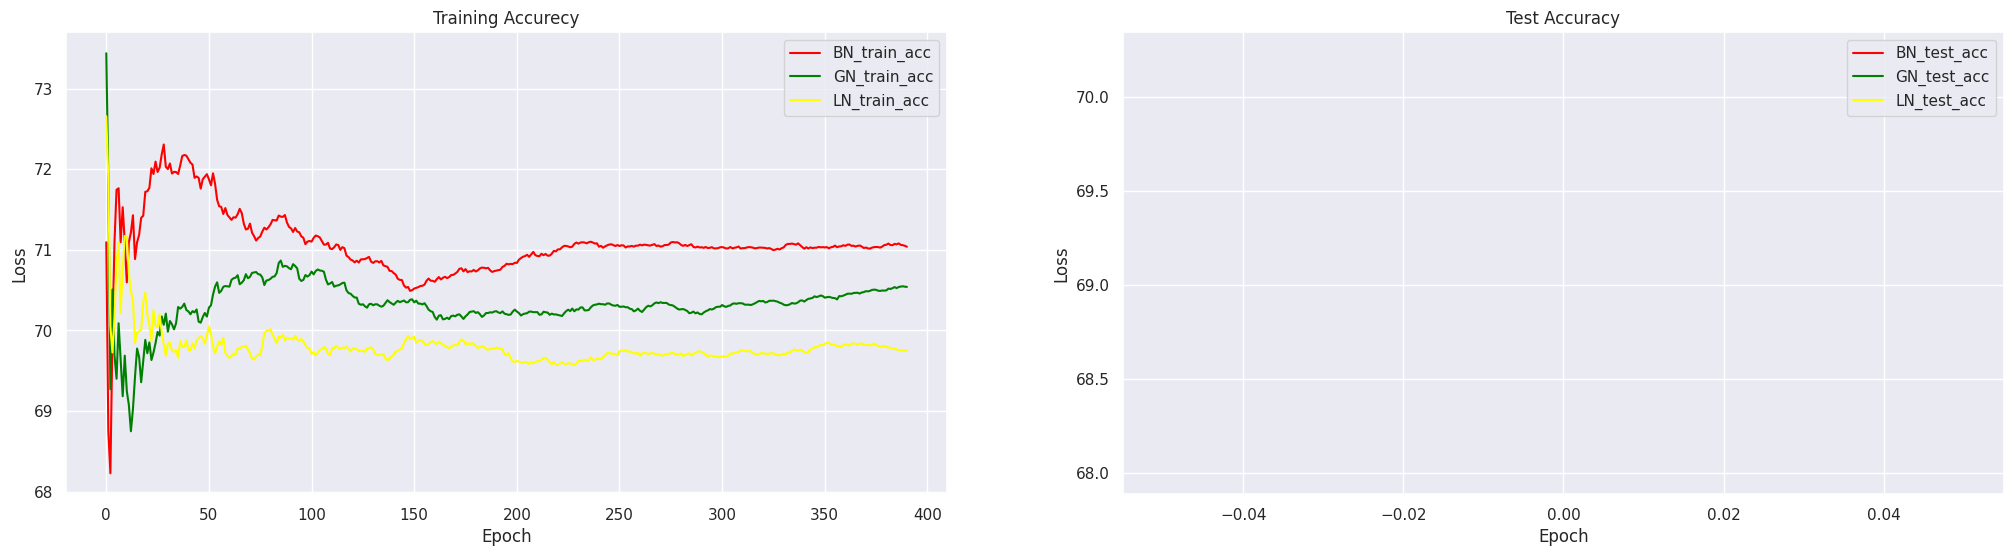

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='whitegrid')

# Increase the plot size and font size.
sns.set(font_scale=1)
plt.rcParams["figure.figsize"] = (25,6)

# Plot the training accurecy.

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(np.array(BN_train_acc), 'red', label="BN_train_acc")
ax1.plot(np.array(GN_train_acc), 'green', label="GN_train_acc")
ax1.plot(np.array(LN_train_acc), 'yellow', label="LN_train_acc")

ax1.set_title("Training Accurecy")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()

# Plot the Test accurecy.

ax2.plot(np.array(BN_test_acc), 'red', label="BN_test_acc")
ax2.plot(np.array(GN_test_acc), 'green', label="GN_test_acc")
ax2.plot(np.array(LN_test_acc), 'yellow', label="LN_test_acc")

# Label the plot.
ax2.set_title("Test Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()

plt.show()

Text(0.5, 1.0, 'Training Accurecy')

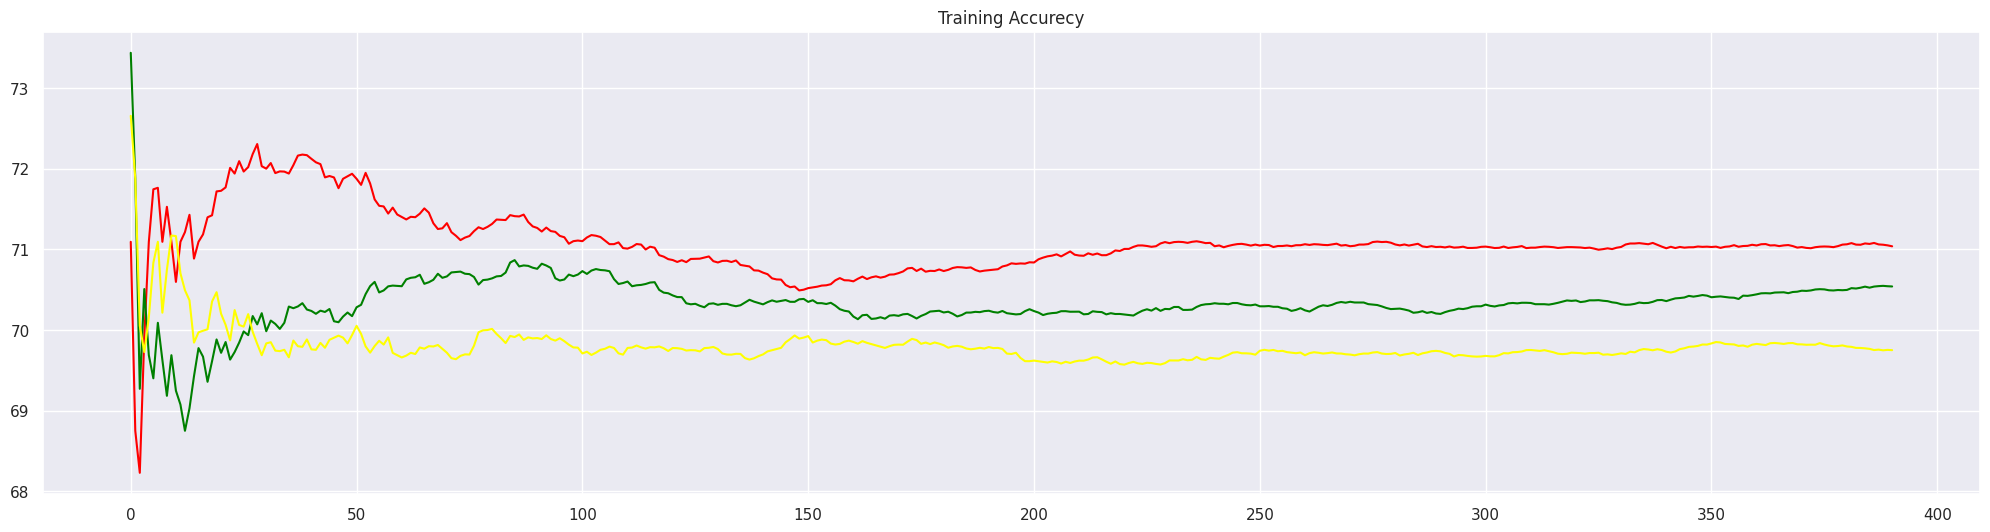

In [19]:
# Training accurecy
fig,ax1 = plt.subplots(1)
ax1.plot(np.array(BN_train_acc), 'red', label="BN_train_acc")
ax1.plot(np.array(GN_train_acc), 'green', label="GN_train_acc")
ax1.plot(np.array(LN_train_acc), 'yellow', label="LN_train_acc")
ax1.set_title("Training Accurecy")

Text(0.5, 1.0, 'Training Accurecy')

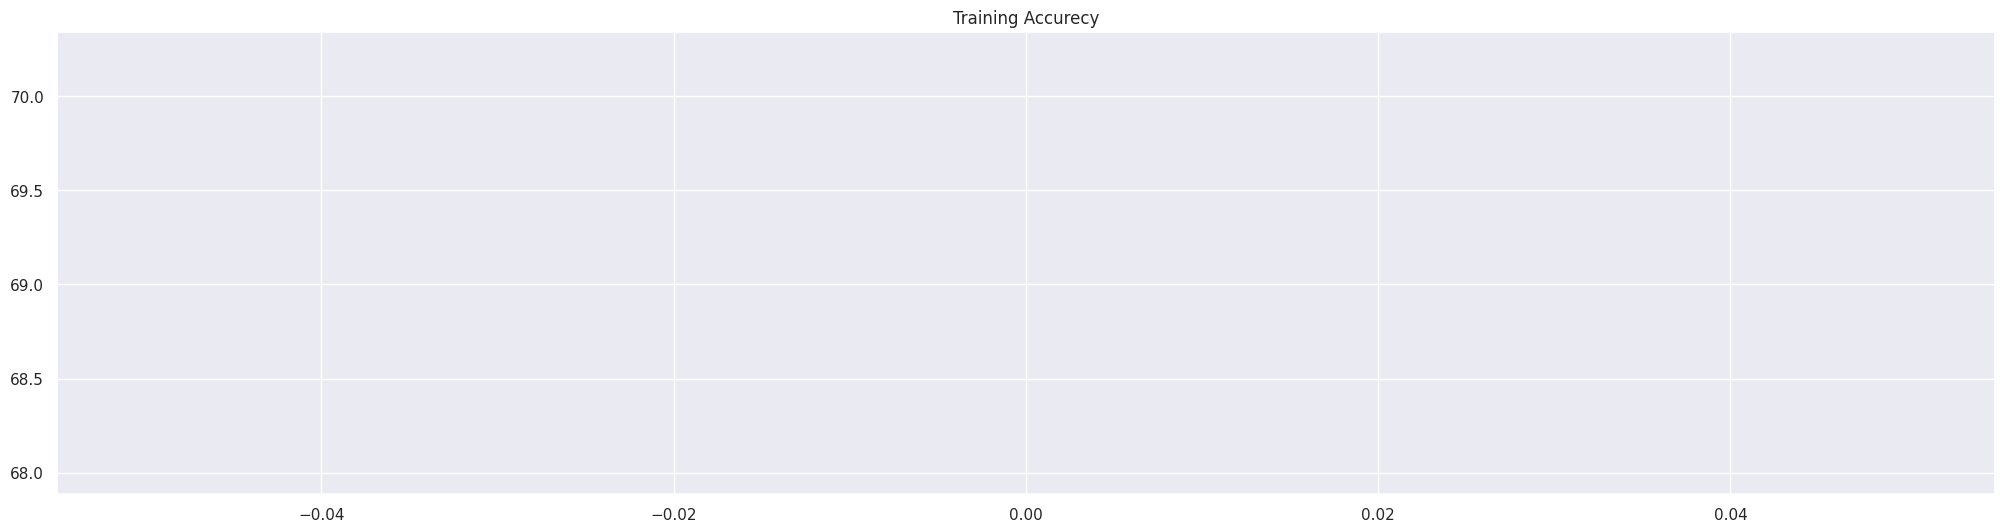

In [20]:
# Test accurecy
fig,ax1 = plt.subplots(1)
ax1.plot(np.array(BN_test_acc), 'red', label="BN_train_acc")
ax1.plot(np.array(GN_test_acc), 'green', label="GN_train_acc")
ax1.plot(np.array(LN_test_acc), 'yellow', label="LN_train_acc")
ax1.set_title("Training Accurecy")

### Missclassified images

In [ ]:
def misclassification(predictions, targets, data, xtitle):
  pred = predictions.view(-1)
  target = targets.view(-1)

  index = 0
  misclassified_image = []

  for label, predict in zip(target, pred):
    if label != predict:
      misclassified_image.append(index)
    index += 1

  plt.figure(figsize=(10,5))
  plt.suptitle(xtitle + ' - Misclassified Images');

  for plot_index, bad_index in enumerate(misclassified_image[0:10]):
    p = plt.subplot(2, 5, plot_index+1)
    p.imshow(data[bad_index].reshape(28,28), cmap='gray')
    p.axis('off')
    p.set_title(f'Pred:{pred[bad_index]}, Actual:{target[bad_index]}')